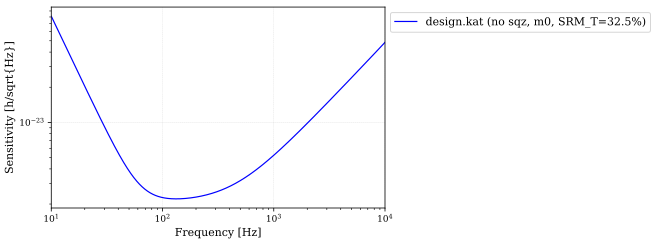

In [174]:
from pykat import finesse
from pykat.commands import *
import pykat.external.peakdetect as peak
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aligoplt
import gwinc as gwinc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

aLIGO = aligo.make_kat()
aLIGO.maxtem = -1 #USE PLANE WAVES MODEL FIRST (speed, complexity...)
TT=0.325 #better match to sites
aLIGO.SRM.setRTL(1-TT-aLIGO.SRM.L,TT,aLIGO.SRM.L)
aLIGO=aligo.setup(aLIGO)

fig,ax=plt.subplots()
freqs=np.logspace(1,4,1000)
aligoplt.strain_sensitivity(aLIGO,ax=ax,
                            lower=freqs[0],upper=freqs[-1],steps=len(freqs),
                            plot_cmds={'label':'design.kat (no sqz, m0, SRM_T=32.5%)'})
plt.legend(loc=2,bbox_to_anchor=(1,1))

In [198]:
print(aLIGO)

% Generated by PyKat 26.02.2020 15:27:57

%%% FTblock laser
l L0 125.0 0.0 0.0 ni
bs jitter 1.0 0.0 0.0 0.0 ni n0 dump dump
s lmod1 1.0 n0 n1
mod mod1 9099471.0 0.18 1 pm 0.0 n1 n2
s lmod2 1.0 n2 n3
mod mod2 45497355.0 0.18 1 pm 0.0 n3 nLaserOut
%%% FTend laser

%%% FTblock IMC
s sIMCin 0.0 nLaserOut nMC1in
bs1 MC1 0.006 0.0 0.0 44.59 nMC1in nMC1refl nMC1trans nMC1fromMC3
s sMC1_MC2 16.24057 nMC1trans nMC2in
bs1 MC2 0.0 0.0 0.0 0.82 nMC2in nMC2refl nMC2trans dump
attr MC2 Rcx 27.24
attr MC2 Rcy 27.24
s sMC2_MC3 16.24057 nMC2refl nMC3in
bs1 MC3 0.006 0.0 0.0 44.59 nMC3in nMC3refl nMC3trans nMCreturn_refl
s sMC3substrate 0.0845 1.44963098985906 nMC3trans nMC3ARin
bs2 MC3AR 0.0 0.0 0.0 28.9661 nMC3ARin dump nIMCout dump
s sMC3_MC1 0.465 nMC3refl nMC1fromMC3
%%% FTend IMC

%%% FTblock HAM2
s sHAM2in 0.4282 nIMCout nIM11
bs1 IM1 0.0 0.0 0.0 53.0 nIM11 nIM12 dump dump
s sIM1_IM2 1.2938 nIM12 nIM21
bs1 IM2 0.0 0.0 0.0 7.0 nIM21 nIM22 dump dump
attr IM2 Rcx 12.8
attr IM2 Rcy 12.8
s sIM2_FI 0.2

-------------------
# Tuning an optic's transmission to achieve a target arm power
<font color='maroon'> last updated Nov 2019. review functionality makes sense (over e.g. lock dragging?) and migrate to script</font>

In [175]:
#original func with added 'setup' switch

def tuneT(LIGOkat,optic='PRM',node='nETMX1',val=0.03,precision=0.025,
          target_precision=0.001,target='max',debug=False,resetup=True):
    """
    scans and optimizes the power at a target node 
    by adjusting the transmissivity of an optic.
    Aims to function much like IFO.scan_to_precision, 
    but for mirror tranmissivities rather than tunings.
    assumes optical loss should be unchanged.
    
    Warning: 
    It's slow! The ifo is re-tuned using setup() for 
    each transmissivity to ensure it's in an operational 
    state.
    
    val = initial value at center of search range
    precision = initial range of search
    target_precision = last step range of search. Setting
            target_precision=None turns off the loop.
    target = power that should be measured at that node.
            Should be a float, or 'max' if aim is to
            maximise, whatever the final value might be.       
    
    """
    if target_precision == None:
        target_precision=precision
    while precision>=target_precision:
        #1. scan over the initial range of T-values
        Pvals=[]
        Tvals = np.linspace(val-precision,val+precision,40)
        for tt in Tvals:
            k = LIGOkat.deepcopy()
            k.parse("pd Pow {}".format(node))
            k.noxaxis=True
            k.components[optic].setRTL(1-tt-k.components[optic].L, tt,k.components[optic].L)
            if resetup:
                #running setup to ensure the ifo is on resonance
                k = aligo.setup(k) # not lock-dragging: we're comparing 2 diff ifos here not drifting states within 1
            o=k.run()
            Pvals.append(o['Pow'])
        #2. find the T-value for which the power is closest to the target
        if target=='max':
            T_out = Tvals[np.argmax(Pvals)]
            P_out = np.max(Pvals)
        else:
            #compare all vals to the target and find the minima
            diffs = [np.abs(P-target) for P in Pvals]#np.abs(Pvals-target)
            _max,_min = peak.peakdetect(diffs,Tvals,1) #not sure we really need a fancy peak detector here...
            Topts = [p[0] for p in _min] #X-vals for the minima. p[1] contains the values of those minima
            Popts = [Pvals[list(Tvals).index(x)] for x in Topts] #Y-vals corresponding to the minima
            #if there's more than one closest match, select the one thats closest to the originally considered value of X (center)
            diffs2 = [abs(x-val) for x in Topts]
            T_out=Topts[np.argmin(diffs2)]
            P_out=Popts[np.argmin(diffs2)]    
        if debug:
            plt.plot(Tvals,Pvals,'-x')
            plt.plot(T_out,P_out,'o')
            plt.xlabel("{} transmission".format(optic))
            plt.ylabel("power at {}".format(node))
            plt.show(block=0)
        val = round(T_out,4)
#         precision = 3*abs(Tvals[1]-Tvals[0]) #new precision looks over 3 steps either side of last run
        precision /= 5
    return val, P_out

MAXIMISING:


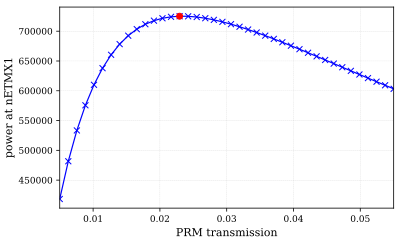

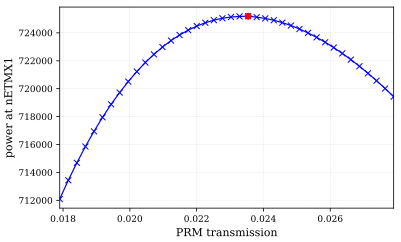

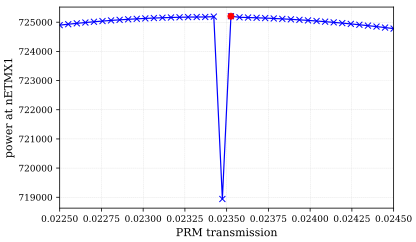

maximum power = 725205.118626481 at T=0.0235
if run without setup() each step:


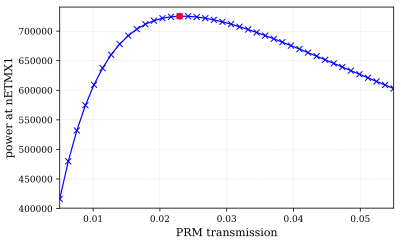

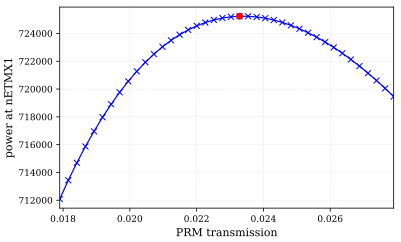

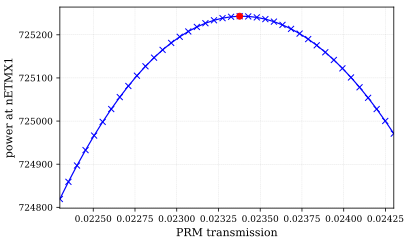

maximum power = 725243.057630375 at T=0.0234

MATCHING:


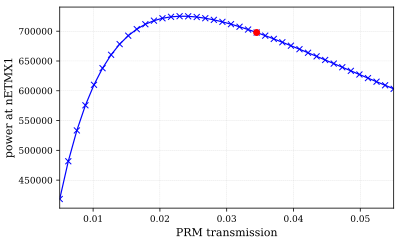

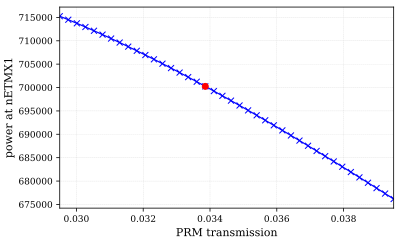

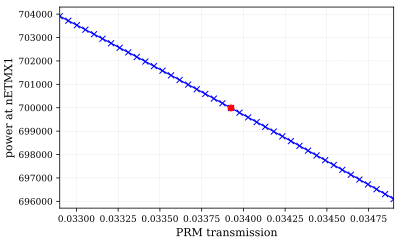

power = 699989.785417113 at T=0.0339 (target was 700000)
if run without setup() each step:


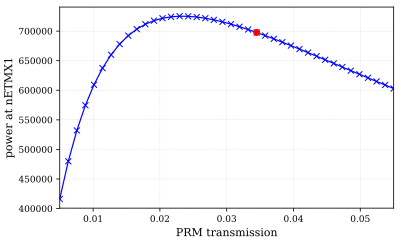

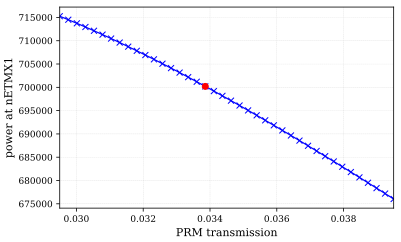

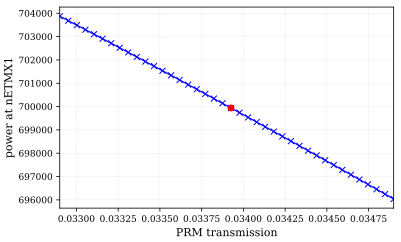

power = 699939.223873343 at T=0.0339 (target was 700000)


In [176]:
print("MAXIMISING:")
T,P = tuneT(aLIGO,debug=True,target_precision=1e-3) 
print("maximum power = {} at T={}".format(P,T))
print("if run without setup() each step:")
T,P = tuneT(aLIGO,debug=True,target_precision=1e-3,resetup=False) 
print("maximum power = {} at T={}".format(P,T))

print("\nMATCHING:")
TT = 700000
T,P = tuneT(aLIGO,debug=True,target=TT) 
print("power = {} at T={} (target was {})".format(P,T,TT))
print("if run without setup() each step:")
T,P = tuneT(aLIGO,debug=True,target=TT,resetup=False) 
print("power = {} at T={} (target was {})".format(P,T,TT))

In [177]:
#updated func using xaxis on transmission - can't run setup each step this way, and can't lock drag if use single run for it.

def quicktuneT(LIGOkat,optic='PRM',node='nETMX1',val=0.03,precision=0.025,
          target_precision=0.001,target='max',debug=False):
    """
    scans and optimizes the power at a target node 
    by adjusting the transmissivity of an optic.
    Aims to function much like IFO.scan_to_precision, 
    but for mirror tranmissivities rather than tunings.
    assumes optical loss should be unchanged.
    
    Warning: 
    It's slow-ish. But importantly, setup() is NOT run
    between T-values, so check it's accuracy vs the above first!
    
    val = initial value at center of search range
    precision = initial range of search
    target_precision = last step range of search. Setting
            target_precision=None turns off the loop.
    target = power that should be measured at that node.
            Should be a float, or 'max' if aim is to
            maximise, whatever the final value might be.       
    
    """
    if target_precision == None:
        target_precision=precision
    while precision>=target_precision:
        ##1. scan over the initial range of T-values
        k=LIGOkat.deepcopy()
        k.removeBlock("locks")
        k.parse("""
        xaxis {} T lin {} {} 40
        func refl = 1 - {:.0f} - ($x1)
        put {} R  refl
        pd Pow {}
        """.format(optic,val-precision,val+precision,float(k.components[optic].L),optic,node))
        o=k.run()
        Tvals=o.x
        Pvals=o['Pow']
            
        ##2. find the T-value for which the power is closest to the target
        if target=='max':
            T_out = Tvals[np.argmax(Pvals)]
            P_out = np.max(Pvals)
        else:
            #compare all vals to the target and find the minima
            diffs = [np.abs(P-target) for P in Pvals]#np.abs(Pvals-target)
            _max,_min = peak.peakdetect(diffs,Tvals,1) #not sure we really need a fancy peak detector here...
            Topts = [p[0] for p in _min] #X-vals for the minima. p[1] contains the values of those minima
            Popts = [Pvals[list(Tvals).index(x)] for x in Topts] #Y-vals corresponding to the minima
            #if there's more than one closest match, select the one thats closest to the originally considered value of X (center)
            diffs2 = [abs(x-val) for x in Topts]
            T_out=Topts[np.argmin(diffs2)]
            P_out=Popts[np.argmin(diffs2)]    
        if debug:
            plt.plot(Tvals,Pvals,'-x')
            plt.plot(T_out,P_out,'o')
            plt.xlabel("{} transmission".format(optic))
            plt.ylabel("power at {}".format(node))
            plt.show(block=0)
        val = round(T_out,4)
#         precision = 3*abs(Tvals[1]-Tvals[0]) #new precision looks over 3 steps either side of last run
        precision /= 5
    return val, P_out


MAXIMISING:


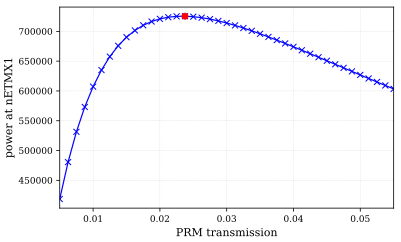

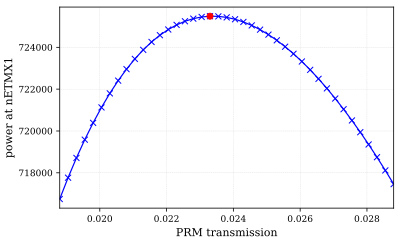

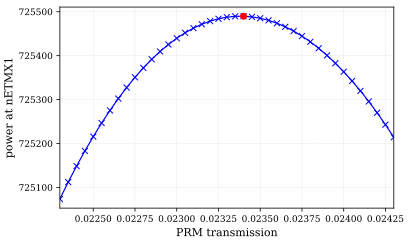

maximum power = 725489.834922178 at T=0.0234

MATCHING:


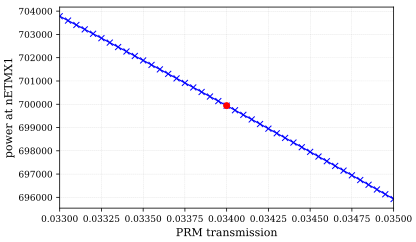

power = 699938.861821864 at T=0.034 (target was 700000)


In [178]:
print("MAXIMISING:")
T,P = quicktuneT(aLIGO,debug=True,target_precision=1e-3) 
print("maximum power = {} at T={}".format(P,T))

print("\nMATCHING:")
TT = 700000
T,P = quicktuneT(aLIGO,debug=True,target=TT) 
print("power = {} at T={} (target was {})".format(P,T,TT))

In [190]:
#updated func using xaxis on transmission - can't run setup each step this way, and can't lock drag if use single run for it.
#this version 2 always opts for the second crossing point if matching a target, rather than whichever is least different

def quicktuneT2(LIGOkat,optic='PRM',node='nETMX1',val=0.03,precision=0.025,
          target_precision=0.001,target='max', res=40, debug=False):
    """
    scans and optimizes the power at a target node 
    by adjusting the transmissivity of an optic.
    Aims to function much like IFO.scan_to_precision, 
    but for mirror tranmissivities rather than tunings.
    assumes optical loss should be unchanged.
    
    Warning: 
    It's slow-ish. But importantly, setup() is NOT run
    between T-values, so check it's accuracy vs the above first!
    The first run should always cover as much of the possible 
    T-value range as possible
    
    val = initial value at center of search range
    precision = initial range of search
    target_precision = last step range of search. Setting
            target_precision=None turns off the loop.
    target = power that should be measured at that node.
            Should be a float, or 'max' if aim is to
            maximise, whatever the final value might be. 
    res = number of steps per run (choose higher if not iterating!)
    
    """
    if target_precision == None:
        target_precision=precision
    while precision>=target_precision:
        ##1. scan over the initial range of T-values
        k=LIGOkat.deepcopy()
        k.removeBlock("locks")
        k.parse("""
        xaxis {} T lin {} {} {}
        func refl = 1 - {:.0f} - ($x1)
        put {} R  refl
        pd Pow {}
        """.format(optic,val-precision,val+precision,res,float(k.components[optic].L),optic,node))
        o=k.run()
        Tvals=o.x
        Pvals=o['Pow']
            
        ##2. find the T-value for which the power is closest to the target
        if target=='max':
            T_out = Tvals[np.argmax(Pvals)]
            P_out = np.max(Pvals)
            if debug:
                plt.plot(Tvals,Pvals,'-x')
        else:
            #compare all vals to the target and find the minima
            diffs = [np.abs(P-target) for P in Pvals]#np.abs(Pvals-target)
            _max,_min = peak.peakdetect(diffs,Tvals,1) #not sure we really need a fancy peak detector here...
            Topts = [p[0] for p in _min] #X-vals for the minima. p[1] contains the values of those minima
            Popts = [Pvals[list(Tvals).index(x)] for x in Topts] #Y-vals corresponding to the minima
#             #if there's more than one closest match, select the one thats closest to the originally considered value of X (center)
#             diffs2 = [abs(x-val) for x in Topts]
#             T_out=Topts[np.argmin(diffs2)]
#             P_out=Popts[np.argmin(diffs2)]    
            # if there's multiple minima, pick the one with higher transmission
            if debug:
                print(Topts)
                plt.plot(Tvals,Pvals,'-x')
            T_out = Topts[-1]
            P_out = Popts[-1]
        if debug:
            plt.plot(T_out,P_out,'o')
            plt.xlabel("{} transmission".format(optic))
            plt.ylabel("power at {}".format(node))
            plt.show(block=0)
        val = round(T_out,4)
#         precision = 3*abs(Tvals[1]-Tvals[0]) #new precision looks over 3 steps either side of last run
        precision /= 5
    return val, P_out


MAXIMISING:


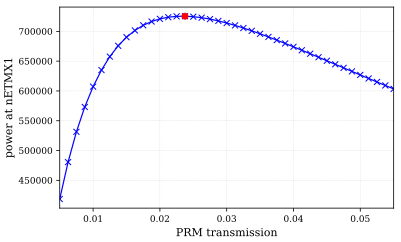

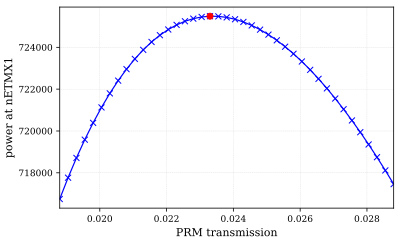

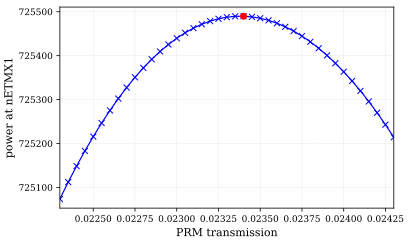

maximum power = 725489.834922178 at T=0.0234

MATCHING:
[0.01625, 0.03375]


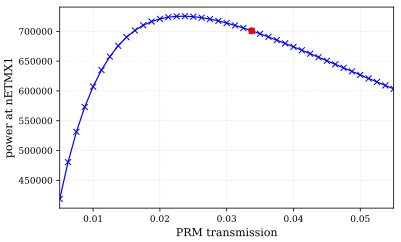

[0.03405]


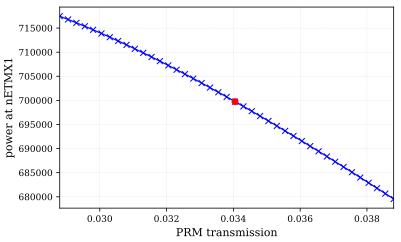

[0.034]


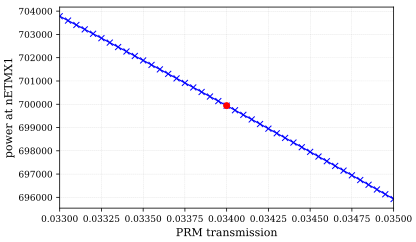

power = 699938.861821864 at T=0.034 (target was 700000)


In [191]:
print("MAXIMISING:")
T,P = quicktuneT2(aLIGO,debug=True,target_precision=1e-3) 
print("maximum power = {} at T={}".format(P,T))

print("\nMATCHING:")
TT = 700000
T,P = quicktuneT2(aLIGO,debug=True,target=TT) 
print("power = {} at T={} (target was {})".format(P,T,TT))

### comparing tools:

In [4]:
print("tuneT:")
print("MAXIMISING:")
T,P = tuneT(aLIGO,debug=False,target_precision=1e-3) 
print("maximum power = {} at T={}".format(P,T))
print("if run without setup() each step:")
T,P = tuneT(aLIGO,debug=False,target_precision=1e-3,resetup=False) 
print("maximum power = {} at T={}".format(P,T))
print("MATCHING:")
TT = 700000
T,P = tuneT(aLIGO,debug=False,target=TT) 
print("power = {} at T={} (target was {})".format(P,T,TT))
print("if run without setup() each step:")
T,P = tuneT(aLIGO,debug=False,target=TT,resetup=False) 
print("power = {} at T={} (target was {})".format(P,T,TT))

print("\nquicktuneT:")
print("MAXIMISING:")
T,P = quicktuneT(aLIGO,debug=False,target_precision=1e-3) 
print("maximum power = {} at T={}".format(P,T))
print("MATCHING:")
TT = 700000
T,P = quicktuneT(aLIGO,debug=False,target=TT) 
print("power = {} at T={} (target was {})".format(P,T,TT))

tuneT:
MAXIMISING:
maximum power = 725205.118626481 at T=0.0235
if run without setup() each step:
maximum power = 725243.057630375 at T=0.0234

MATCHING:
power = 699989.785417113 at T=0.0339 (target was 700000)
if run without setup() each step:
power = 699939.223873343 at T=0.0339 (target was 700000)
quicktuneT:
MAXIMISING:
maximum power = 725489.834922171 at T=0.0234

MATCHING:
power = 699938.861821864 at T=0.034 (target was 700000)


In [ ]:
print("""
tuneT:
MAX power diff wsetup-nosetup/nosetup = {:.3f}%
MAT power diff wsetup-nosetup/nosetup = {:.3f}%


""")

-------------
# Tuning an optic's transmission to achieve a target pole frequency
<font color='magenta'>Work In Progress, started Feb 11th 2020</font>

In [ ]:
from scipy.interpolate import interp1d
def DARM_TF(_kat,optics=["ETMX","ETMY"],label=None,maxtem=None,
            ls='-',lw=1,plotit=False, printit = True,getfp = False):
    #
    """
    from squeezing_MM LLO ifo_design_tools study. 
    Updated Feb 2020 to specify which fpole method you use. 
    updated version of old_DARM_TF. outputs two pole values:
    fp1 = freq where sig amplitude drops to max/√2 (NB sqrt missing from old_DARM_TF, seems to be the main issue there)
    fp2 = freq where sig phase changes by -45deg *relative to starting value*
    
    commands:
    _kat   = supplied finesse model (will be deepcopied for use)
    optics = optics to be differentially shaken
    label  = title if plotted
    maxtem = max HOM order used by simulation (otherwise uses the one set in _kat)
    ls, lw = plotting instructions
    plotit = show the plot resulting from the calculations
    getfp = return the pole frequency as calculated via both methods above. 
            if True, returns out.x, out['TF'], fp, fp2    """
    kat = _kat.deepcopy()
    kat.ETMX.mass = np.inf
    kat.ITMX.mass = np.inf
    kat.ETMY.mass = np.inf
    kat.ITMY.mass = np.inf
    kat.parse("""
    fsig darm  {ax} 1 0
    fsig darm2 {ay} 1 180
    xaxis darm f log 1 10k 1000 #all fsigs get same freq so don't need a put here
    yaxis log abs:deg
    pd1 DARM_TF 1 nAS
    put DARM_TF f $x1
    """.format(ax=optics[0],ay=optics[1]))
    if maxtem != None:
        kat.maxtem = maxtem   
    out = kat.run()
    
    if plotit:
        fig = out.plot(title=label,detectors=["DARM_TF"],show=False,return_fig=True)
        
    if getfp:
    
        def M1(xx,YY):
            #Method 1: from power drop
            Y = abs(YY)
            f = interp1d(Y,xx)
            Ymax = max(Y)
            ymaxidx = list(Y).index(Ymax)
            Xmax = out.x[ymaxidx]
            Yfp = Ymax/np.sqrt(2)
            fp = f(Yfp)
            if printit:
                print("fp  = {:.3f}Hz [amplitude drops to 1/sqrt(2) from max value]".format(fp))
            return fp,Yfp,Xmax,Ymax
        
        def M2(xx,YY):
            #Method 2: from phase change - dependent on starting well below pole freq (uses phi_0 reference)
            Yphi = np.angle(YY,deg=True)
            f2 = interp1d(Yphi,xx)
            fp2 = f2(Yphi[0]-45)
            if printit:
                print("fp2 = {:.3f}Hz [phase shifts by -45deg from initial value]".format(fp2))
            return fp2,Yphi[0]-45
        
        if getfp=='fp1':
            fp1,Yfp,Xmax,Ymax = M1(out.x,out["DARM_TF"])
            if plotit:
                ax0 = fig.axes[0]
                ax0.loglog(Xmax,Ymax,'ro',label='peak')
                ax0.loglog(fp1,Yfp,'kx',label="f_p = {:.3f}Hz\n[amp=max/√2]".format(float(fp1)))
                ax0.legend(loc=2,bbox_to_anchor=(1,1))
                plt.show()
            return fp1
            
        if getfp=='fp2':
            fp2,Yfp2 = M2(out.x,out["DARM_TF"])
            if plotit:
                ax1 = fig.axes[1]
                ax1.semilogx(fp2,Yfp2,'kx',label="f_p2 = {:.3f}Hz\n[phase=$\phi_0$-45deg]".format(float(fp2)))
                ax1.legend(loc=2,bbox_to_anchor=(1,1))
                plt.show()
            return fp2
        
        if getfp=='both':
            fp1,Yfp,Xmax,Ymax = M1(out.x,out["DARM_TF"])
            fp2,Yfp2 = M2(out.x,out["DARM_TF"])
            if plotit:
                ax0 = fig.axes[0]
                ax0.loglog(Xmax,Ymax,'ro',label='peak')
                ax0.loglog(fp1,Yfp,'kx',label="f_p = {:.3f}Hz\n[amp=max/√2]".format(float(fp1)))
                ax0.legend(loc=2,bbox_to_anchor=(1,1))
                ax1 = fig.axes[1]
                ax1.semilogx(fp2,Yfp2,'kx',label="f_p2 = {:.3f}Hz\n[phase=$\phi_0$-45deg]".format(float(fp2)))
                ax1.legend(loc=2,bbox_to_anchor=(1,1))
                plt.show()
            return [fp1,fp2]
            
        
    else: return out.x,out["DARM_TF"]
                
        

In [ ]:
DARM_TF(aLIGO,optics=["LX","LY"],plotit=True, getfp ='fp1')    
DARM_TF(aLIGO,optics=["LX","LY"],plotit=True, getfp ='fp2')
DARM_TF(aLIGO,optics=["ETMX","ETMY"],plotit=True, getfp ='both')
# k = aLIGO.deepcopy()
# k.SRM.setRTL(1-aLIGO.SRM.L-0.2,0.2,aLIGO.SRM.L)#old SRM value
# k = aligo.setup(k)
# k.removeBlock("locks")
# DARM_TF(k,optics=["LX","LY"],plotit=False, getfp ='fp1')
# DARM_TF(k,optics=["LX","LY"],plotit=False, getfp ='fp2')



### version 1: an iterator. specify an initial parameter value and range, then scan 4 points in that range repeatedly over smaller ranges (/3 each time) until the pole freq is reached, to within a specified accuracy of that parameter. 

In [114]:
from pykat.external.progressbar import ProgressBar

def tuneTfp(_kat,target=450,optic='SRM',val=0.325,precision=0.1, verify=True,
          target_precision=0.001,debug=False,deepdebug=False,fpmethod='phase'):
    """
    scans and optimizes the DARM pole
    by adjusting the transmissivity of an optic.
    Assumes optical loss should be unchanged.
    
    Warning: 
    It's slow! The ifo is re-tuned using setup() for 
    each transmissivity to ensure it's in an operational 
    state.
    
    val = initial value at center of search range
    precision = initial range of search
    target_precision = last step range of search. Setting
            target_precision=None turns off the loop.
    target = DARM pole that should be measured.   
    fpmethod = method used to identify pole frequency (phase or amplitude)
    verify = re-run Finesse using the value from interpolation to check the result

    
    """
    print("\n>>version 1")
    if fpmethod=='amplitude':
        fpm = 'fp1'
    else:
        fpm = 'fp2' #defaults to using phase method
    if target_precision == None or target_precision == False:
        target_precision=precision
    else:
        psf = 3
#         print('[overall progress overlays indiv bars at end of each run...]')
        pb0 = ProgressBar()
        pb0.maxval = int(np.log(precision/target_precision)/np.log(psf)+1)
        j=0
    while precision>=target_precision:
        ##1. scan over the initial range of T-values
        Tvals = np.linspace(val-precision,val+precision,4)
        poles = []
#         print("current run: {}±{} [target precision: {}]".format(val,precision,target_precision))
#         pb = ProgressBar()
#         pb.maxval = len(Tvals)
#         i=0
        for T in Tvals:
            k=_kat.deepcopy()
            LL = k.components[optic].L
            k.components[optic].setRTL(1-T-LL,T,LL)
            k = aligo.setup(k)
            poles.append(DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2'))
#             i+=1
#             pb.update(i)
        if debug:
            fig,ax=plt.subplots()
            ax.plot(Tvals,poles)
            
        ##2. find the T-value for which the pole is closest to the target
        
        #VERSION A: minimum difference to target
        #compare all vals to the target and find the minima
        diffs = [np.abs(P-target) for P in poles]
        Topt = Tvals[diffs.index(min(diffs))]
        fpopt = poles[diffs.index(min(diffs))]
        if debug:
            ax.plot(Topt,fpopt,'o')
            fig.show()  
        val = round(Topt,4)
        if pb0:
            j+=1
            pb0.update(j)
        precision /= psf
    
            
    if verify:
        print('verifying...')
        k=_kat.deepcopy()
        LL = k.components[optic].L
        k.components[optic].setRTL(1-T-LL,T,LL)
        k = aligo.setup(k)
        newpole = DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2')
        print('found pole: {:1f}Hz; target was {:.1f}Hz'.format(newpole,target))
        if int(newpole-target)!=0:
            print('new value is more than 1Hz away from target. we have an issue.')
        
    return val, fpopt

# tuneTfp(aLIGO,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
#           target_precision=0.001,debug=False,deepdebug=False,fpmethod='phase')


### version 2: just scan the full range of possible values, interpolate, and set the parameter value from there (check it afterwards)

In [145]:
from pykat.external.progressbar import ProgressBar
from scipy import interp

def tuneTfp_I(_kat,target=450,optic='SRM',loss = 0, Tsteps=40,
            debug=False,deepdebug=False,fpmethod='phase',verify=True):
    """
    scans the transmission of the specified optic 
    and measures the DARM pole, then interpolates to 
    find the exact transmission that gives the target pole freq.
    
    Warning: 
    It's slow! The ifo is re-tuned using setup() for 
    each transmissivity to ensure it's at an operating point.
    
    target = DARM pole that should be measured.
    optic = optic whose transmission we vary
    loss = static loss on that optic
    Tsteps = number of points in initial scan
    debug = show plot
    deepdebug = show plots of each pole measurement
    fpmethod = method used to identify pole frequency (phase or amplitude)
    verify = re-run Finesse using the value from interpolation to check the result
    
    """
    print("\n>>version 2")
    if fpmethod=='amplitude':
        fpm = 'fp1'
    else:
        fpm = 'fp2' #defaults to using phase method

    Tvals = np.linspace(1e-6,1-1e-6-loss,Tsteps)#small offsets from top and bottom so we always have pretuning signals for setup()
    poles = []

    pb = ProgressBar()
    pb.maxval = len(Tvals)
    i=0
    for T in Tvals:
        k=_kat.deepcopy()
        k.components[optic].setRTL(1-T-loss,T,loss)
        k = aligo.setup(k)
        poles.append(DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2'))
        i+=1
        pb.update(i)
    if debug:
        fig,ax=plt.subplots()
        ax.plot(Tvals,poles)
        fig.show()
    
    f = interp1d(poles,Tvals)
    Topt = f(target)
    
    if debug:
        testffs = np.linspace(min(poles),max(poles),Tsteps*10)
        fig,ax=plt.subplots()
        ax.plot(Tvals,poles)
        ax.plot(f(testffs),testffs,'--',lw=2,color='g',alpha=0.5,label='interpolated line')
        ax.plot(Topt,target,'x',label='fp={}Hz, T={:.3f}'.format(target,Topt))
        ax.set_xlabel('{}_T'.format(optic))
        ax.set_ylabel('DARM pole [Hz]')
        ax.legend()
        fig.show()
        
    if verify:
        print('verifying...')
        k=_kat.deepcopy()
        k.components[optic].setRTL(1-Topt-loss,Topt,loss)
        k = aligo.setup(k)
        newpole = DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2')
        print('found pole: {:1f}Hz; target was {:.1f}Hz'.format(newpole,target))
        if int(newpole-target)!=0:
            print('new value is more than 1Hz away from target. we have an issue. Try increasing Tsteps...')

    return Topt

# tuneTfp_I(aLIGO,loss = aLIGO.SRM.L, Tsteps=30,debug=True,verify=True)

### version 3: it's a pretty smooth slope so just read the current value and one step significantly away from it, infer the slope, guess the value, then repeat on a smaller scale...or something like that

In [146]:
from pykat.external.progressbar import ProgressBar

def tuneTfp2(_kat,target=450,optic='SRM',val=0.325,precision=0.1,
          target_precision=0.001,fpmethod='phase',
            debug=False,deepdebug=False,verify=True):
    """
    scans and optimizes the DARM pole
    by adjusting the transmissivity of an optic.
    Assumes optical loss should be unchanged.
    
    Warning: 
    It's slow! The ifo is re-tuned using setup() for 
    each transmissivity to ensure it's in an operational 
    state.
    
    val = initial value at center of search range
    precision = initial range of search
    target_precision = last step range of search. Setting
            target_precision=None turns off the loop.
    target = DARM pole that should be measured.   
    fpmethod = method used to identify pole frequency (phase or amplitude)
    verify = re-run Finesse using the value from interpolation to check the result
    
    """
    print("\n>>version 3")
    if fpmethod=='amplitude':
        fpm = 'fp1'
    else:
        fpm = 'fp2' #defaults to using phase method
    if target_precision == None or target_precision == False:
        target_precision=precision
    else:
        psf=2
        pb = ProgressBar()
        pb.maxval = int(np.log(precision/target_precision)/np.log(psf)+1)
        i=0
    while precision>=target_precision:
        ##1. scan over the initial range of T-values
        Tvals = [val-precision,val+precision]
        poles = []
        
        for T in Tvals:
            k=_kat.deepcopy()
            LL = k.components[optic].L
            k.components[optic].setRTL(1-T-LL,T,LL)
            k = aligo.setup(k)
            poles.append(DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2'))

        if debug:
            fig,ax=plt.subplots()
            ax.plot(Tvals,poles)
            
        ##2. find the T-value for which the pole is closest to the target
        grad = (poles[1]-poles[0])/(Tvals[1]-Tvals[0])
        const = poles[0]- grad * Tvals[0]
        val = (target-const)/grad
        if debug:
            ax.plot(val,target,'o')
            fig.show()  
            
        precision /= psf
        if pb:
            i+=1
            pb.update(i)
            
        
    if verify:
        print('verifying...')
        k=_kat.deepcopy()
        LL = k.components[optic].L
        k.components[optic].setRTL(1-T-LL,T,LL)
        k = aligo.setup(k)
        newpole = DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2')
        print('found pole: {:1f}Hz; target was {:.1f}Hz'.format(newpole,target))
        if int(newpole-target)!=0:
            print('new value is more than 1Hz away from target. we have an issue.')

    return val

# tuneTfp2(aLIGO,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
#           target_precision=1e-4,debug=False,deepdebug=False,fpmethod='phase')


### version 4: multi-stage interpolation based on v2
hopeful advantages: faster than v2, and still doesn't require value or precision presets being set ok to get a decent result

In [147]:
from pykat.external.progressbar import ProgressBar

def tuneTfp_I2(_kat,target=450,optic='SRM',loss = 0, Tsteps=8, fprecision=1, Tthresh=1e-4,
            debug=False,deepdebug=False,fpmethod='phase'):
    """
    scans the transmission of the specified optic 
    and measures the DARM pole, then interpolates to 
    find the exact transmission that gives the target pole freq.
    
    target = DARM pole that should be measured.
    optic = optic whose transmission we vary
    loss = static loss on that optic
    Tsteps = number of points in initial scan
    debug = show plot
    deepdebug = show plots of each pole measurement
    fpmethod = method used to identify pole frequency (phase or amplitude)
    verify = re-run Finesse using the value from interpolation to check the result
    fprecision = max difference between fp_out and target value allowed
    Tthresh = threshold of narrowest range of transmission values to consider
    
    """
    print("\n>>version 4")
    if fpmethod=='amplitude':
        fpm = 'fp1'
    else:
        fpm = 'fp2' #defaults to using phase method
        
    if debug:
        fig,ax=plt.subplots()
    
    newpole = 0
    rng=1
    jj=0
    Topt=None
    while abs(newpole-target)>fprecision:
        print("stage {}".format(jj))
    
        if Topt:
            Tvals = np.linspace(Topt-rng, Topt+rng,Tsteps)
        else: #first run: small offsets from top and bottom so we always have pretuning signals for setup()
            Tvals = np.linspace(1e-6,1-1e-6-loss,Tsteps)
            
        if max(Tvals)-min(Tvals) < Tthresh:
            print('Tval range narrower than threshold ({}), stopping.'.format(Tthresh))
            return Topt
        
        else:
            poles = []

            pb = ProgressBar()
            pb.maxval = len(Tvals)

            i=0
            for T in Tvals:
                k=_kat.deepcopy()
                k.components[optic].setRTL(1-T-loss,T,loss)
                k = aligo.setup(k)
                poles.append(DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2'))
                i+=1
                pb.update(i)
            if debug:
                #for now to check the initial run
                f,a=plt.subplots()
                a.plot(Tvals,poles,label='stage {} full run'.format(jj))
                f.show()
                #for the full stepping-in plot
                ax.plot(Tvals,poles,label='stage {} full run'.format(jj))
                

            f = interp1d(poles,Tvals)
            Topt = f(target)


            if debug:
                testffs = np.linspace(min(poles),max(poles),Tsteps*10)
                ax.plot(f(testffs),testffs,'--',lw=2,alpha=0.5,label='stage {} interpolated line'.format(jj))
                ax.plot(Topt,target,'x',label='stage {}: T={:.3f}'.format(jj,Topt))

            print('verifying...')
            k=_kat.deepcopy()
            k.components[optic].setRTL(1-Topt-loss,Topt,loss)
            k = aligo.setup(k)
            newpole = DARM_TF(k,optics=["LX","LY"],plotit=deepdebug,printit=False,getfp ='fp2')
            print('found pole: {:1f}Hz; target was {:.1f}Hz'.format(newpole,target))
            if abs(newpole-target)>fprecision:
                print('new value is more than {:g}Hz away from target. Running again over narrower range.'.format(fprecision))
                rng/=10
                jj+=1

        if debug:
            ax.set_xlabel('{}_T'.format(optic))
            ax.set_ylabel('DARM pole [Hz]')
            ax.legend()
            fig.show()
            

    return Topt

# tuneTfp_I2(aLIGO,loss = aLIGO.SRM.L,debug=True)

### comparing tools:


PLANE WAVE:

>>version 1


100% (5 of 5) |###########################| Elapsed Time: 0:00:54 ETA:  0:00:00

verifying...
found pole: 449.244189Hz; target was 450.0Hz

>>version 2


100% (30 of 30) |#########################| Elapsed Time: 0:01:42 ETA:  0:00:00

verifying...
found pole: 449.935583Hz; target was 450.0Hz

>>version 3


100% (10 of 10) |#########################| Elapsed Time: 0:01:03 ETA:  0:00:00

verifying...
found pole: 449.664565Hz; target was 450.0Hz

>>version 4
stage 0


100% (8 of 8) |###########################| Elapsed Time: 0:00:24 ETA:  0:00:00

verifying...
found pole: 434.830727Hz; target was 450.0Hz
new value is more than 1Hz away from target. Running again over narrower range.
stage 1


100% (8 of 8) |###########################| Elapsed Time: 0:00:24 ETA:  0:00:00

verifying...
found pole: 449.352416Hz; target was 450.0Hz
(0.3103, array(450.65658171)) 0.31073146048267986 0.3106939712972041 0.3110714416092088


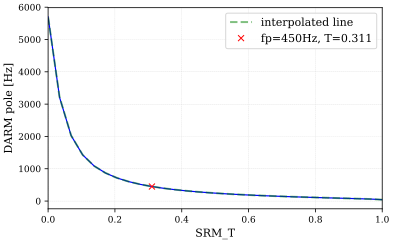

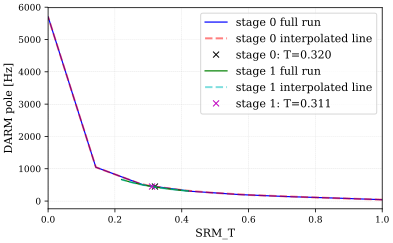

In [119]:
kat = aLIGO.deepcopy()

print("PLANE WAVE:")
kat.maxtem=-1
kat=aligo.setup(kat)
kat.removeBlock("locks")

T_SRM_1=tuneTfp(kat,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
          target_precision=0.001,debug=False,deepdebug=False,fpmethod='phase')
T_SRM_2=tuneTfp_I(kat,loss = aLIGO.SRM.L, Tsteps=30,debug=True,verify=True)
T_SRM_3=tuneTfp2(kat,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
          target_precision=1e-4,debug=False,deepdebug=False,fpmethod='phase')
T_SRM_4=tuneTfp_I2(kat,loss = aLIGO.SRM.L,debug=True)
print(T_SRM_1,T_SRM_2,T_SRM_3,T_SRM_4)




maxtem 2:

>>version 1


100% (7 of 7) |###########################| Elapsed Time: 0:04:12 ETA:  0:00:00

verifying...
found pole: 449.574262Hz; target was 450.0Hz

>>version 2


100% (30 of 30) |#########################| Elapsed Time: 0:06:16 ETA:  0:00:00

verifying...
found pole: 449.954889Hz; target was 450.0Hz

>>version 3


100% (10 of 10) |#########################| Elapsed Time: 0:03:01 ETA:  0:00:00

verifying...
found pole: 449.665331Hz; target was 450.0Hz

>>version 4
stage 0


100% (8 of 8) |###########################| Elapsed Time: 0:02:12 ETA:  0:00:00

verifying...
found pole: 435.212827Hz; target was 450.0Hz
new value is more than 1Hz away from target. Running again over narrower range.
stage 1


100% (8 of 8) |###########################| Elapsed Time: 0:01:14 ETA:  0:00:00

verifying...
found pole: 449.334745Hz; target was 450.0Hz
(0.3101, array(450.04389518)) 0.31011480718134055 0.3100885071457638 0.31047716482889126


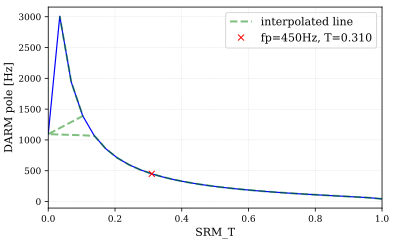

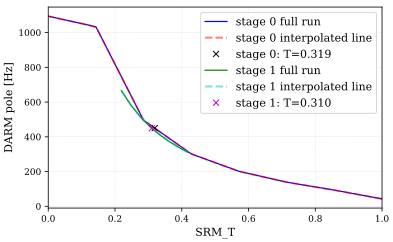

In [137]:
print("\n\nmaxtem 2:")
kat.maxtem=2
kat=aligo.setup(kat)
kat.removeBlock("locks")

T_SRM_1=tuneTfp(kat,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
          target_precision=1e-4,debug=False,deepdebug=False,fpmethod='phase')
T_SRM_2=tuneTfp_I(kat,loss = aLIGO.SRM.L, Tsteps=30,debug=True,verify=True)#why does this *sometimes* bug out??
T_SRM_3=tuneTfp2(kat,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
          target_precision=1e-4,debug=False,deepdebug=False,fpmethod='phase')
T_SRM_4=tuneTfp_I2(kat,loss = aLIGO.SRM.L,debug=True)
print(T_SRM_1,T_SRM_2,T_SRM_3,T_SRM_4)

In [133]:
#version 1 failed to meet the target within 1Hz, can we make it do better without adding the fprecision loop?
T_SRM_1=tuneTfp(kat,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
          target_precision=1e-4,debug=False,deepdebug=False,fpmethod='phase')
##YES - but target_precision now an order of magnitude smaller. hopefully stay same for higher maxtem!


>>version 1


100% (7 of 7) |###########################| Elapsed Time: 0:04:09 ETA:  0:00:00

verifying...
found pole: 449.576709Hz; target was 450.0Hz


In [124]:
##why did this one *sometimes* crash above? (commented out above)
T_SRM_2=tuneTfp_I(kat,loss = aLIGO.SRM.L, Tsteps=30,debug=True,verify=True)
# T_SRM_2=tuneTfp_I(kat,loss = aLIGO.SRM.L, Tsteps=30,debug=True,verify=True,deepdebug=True)
##UNKNOWN. seems to work now...not sure why (I only reran cells)...something fishy either with v1 or v2...


>>version 2


100% (30 of 30) |#########################| Elapsed Time: 0:06:09 ETA:  0:00:00

verifying...
found pole: 449.975324Hz; target was 450.0Hz


In [143]:
print("\n\nmaxtem 4:")
kat.maxtem=4
kat=aligo.setup(kat)
kat.removeBlock("locks")

T_SRM_1=tuneTfp(kat,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
          target_precision=1e-4,debug=False,deepdebug=False,fpmethod='phase')



maxtem 4:

>>version 1


100% (7 of 7) |###########################| Elapsed Time: 0:22:54 ETA:  0:00:00

verifying...
found pole: 449.568470Hz; target was 450.0Hz



>>version 2


100% (30 of 30) |#########################| Elapsed Time: 0:37:17 ETA:  0:00:00

verifying...
found pole: 449.955892Hz; target was 450.0Hz


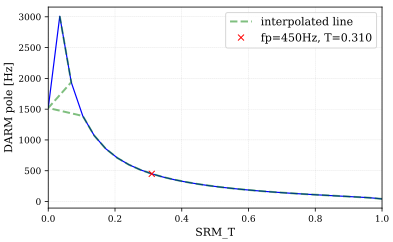

In [149]:
T_SRM_2=tuneTfp_I(kat,loss = aLIGO.SRM.L, Tsteps=30,debug=True,verify=True)#why does this *sometimes* bug out??
#" A value in x_new is below the interpolation range."

In [141]:
T_SRM_3=tuneTfp2(kat,target=450,optic='SRM',val=0.3,precision=0.1,verify=True,
          target_precision=1e-4,debug=False,deepdebug=False,fpmethod='phase')


>>version 3


100% (10 of 10) |#########################| Elapsed Time: 0:17:33 ETA:  0:00:00

verifying...
found pole: 449.665312Hz; target was 450.0Hz



>>version 4
stage 0

Keyboard interrupt caught, stopped simulation.



AttributeError: 'NoneType' object has no attribute 'x'

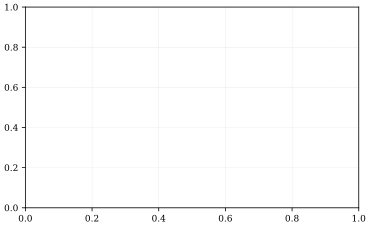

In [164]:
T_SRM_4=tuneTfp_I2(kat,loss = aLIGO.SRM.L,debug=True)#ooh now this one bugged out too...
# print(T_SRM_1,T_SRM_2,T_SRM_3,T_SRM_4)

### alternate method using scipy optimize??

In [173]:
# scipy.optimize.minimize(fun, x0, args=(), method=None, 
#                         jac=None, hess=None, hessp=None, bounds=None, 
#                         constraints=(), tol=None, callback=None, options=None)
from scipy.optimize import minimize

def myfunc(T,targetf,_kat):
    k=_kat.deepcopy()
    loss = k.SRM.L
    k.SRM.setRTL(1-T-loss,T,loss)
    k = aligo.setup(k)
    fpole = DARM_TF(k,optics=["LX","LY"],plotit=False,printit=False,getfp ='fp2')
    print(fpole)
    return abs(targetf - fpole)

outval=minimize(myfunc,0.3,args=(450,aLIGO),bounds=[(2*aLIGO.SRM.L,1-2*aLIGO.SRM.L)],tol=0.5)
print('------------------------ done; T={}'.format(outval.x[0]))
print()

outval=minimize(myfunc,0.2,args=(450,aLIGO),bounds=[(2*aLIGO.SRM.L,1-2*aLIGO.SRM.L)],tol=0.5)
print('------------------------ done; T={}'.format(outval.x[0]))
# ##I mean it works, kinda, 
# but it's not as informative about what it's doing unless I make the func print it
# and seems to not work if the initial guess is off.
#but it is FAST

kk = aLIGO.deepcopy()
kk.maxtem=4
outval=minimize(myfunc,0.3,args=(450,kk),bounds=[(2*aLIGO.SRM.L,1-2*aLIGO.SRM.L)],tol=0.5)
print('------------------------ done; T={}'.format(outval.x[0]))

468.9530631209754
468.9530448402747
43.08113939473435
43.08099631038454
164.7406608883967
164.74065662686615
365.8928504382925
365.8928381520867
444.6116736624773
444.611656937095
455.98242212486895
455.98240465740577
449.85414004117894
449.8541228830198
450.7383769046502
450.7383597243699
449.85414004117894
449.8541228830198
------------------------ done; T=0.31077892395853185

738.6768655609644
738.6768257842566
43.08113939473435
43.08099631038454
170.22390336161175
170.2238989720187
------------------------ done; T=0.6365877209952076
467.8169549571182
467.8169367575159
42.790163955140606
42.71921274980266
156.99916043350498
156.99915639860214
360.76866733676803
360.76865526869227
443.06949896327717
443.06948231694946
454.6390151469337
454.63899775753606
448.6564334210379
448.65641648821554
451.6043569169051
451.6043397571077
449.95059960192975
449.95058248285903
449.95059960192975
449.95058248285903
------------------------ done; T=0.3101354957251573
